# Airborne magnetic survey of Afghanistan

https://ngdc.noaa.gov/geomag/aromag.shtml

License: [public domain](https://www.ngdc.noaa.gov/ngdcinfo/privacy.html#copyright-notice)

In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import verde as vd
import pooch
import pyproj
import pygmt

## Download the data archive

Use Pooch to download the data archive and fetch the CSV file only (not the PDF reports included).

In [3]:
surveys = "06G 06C 06H 06F 06D 06B 08A 06E 06A".lower().split()
hashes = [
    "sha256:8469c1a4244ba4a505a199f9258ec47409efb8c09607a1d7d038cc32243f9c99",
    "sha256:045895371fee9f7f4873541a8092fd513070a81f238423c9cfb508da8ff655a9",
    "sha256:f080967ea5730e6e7ea95b0586d54f5b31d1d6475c1c77a0c86088d843b643a2",
    "sha256:beacc36ce205ff507724a2a65d1985fbb8734e609662fc4336bf17792944ac13",
    "sha256:f44aab329b3bcf8ab2260c63cbdf35feb1c993b1646b77bc747816b506126b96",
    "sha256:5e71f99c1a1de5be9e8fb4f8c9a162851eb758c5d6baace66c2c67b536732cd5",
    "sha256:a905e49db417fff5c4e087203c6455f4e7bc3a386e67abfa8f2f36b8da027f20",
    "sha256:8ee85a167dc904085aab6bdb88155171a5a1cefc71e51fdea3a920d86e324f4f",
    "sha256:a5129bc3e0ad6e13c527c0115aef135508987712f371b19788fd3aef189470ee",
]
surveys = "08A 06A".lower().split()
hashes = [
    "sha256:a905e49db417fff5c4e087203c6455f4e7bc3a386e67abfa8f2f36b8da027f20",
    "sha256:a5129bc3e0ad6e13c527c0115aef135508987712f371b19788fd3aef189470ee",
]
fnames = []
for survey, sha_hash in zip(surveys, hashes):
    url = f"https://www.ngdc.noaa.gov/mgg/trk/aeromag/nrl_afghanistan/afghan_mag{survey}/afghan_mag{survey}.zip"
    data_file = f"afghan_mag{survey}/data/mag88t/afghan_mag{survey}.m88t"
    fname = pooch.retrieve(
        url,
        known_hash=sha_hash,
        # Unpack and return only the actual data, not the reports.
        processor=pooch.Unzip(members=[data_file]),
    )
    fnames.append(fname[0])

Extracting 'afghan_mag08a/data/mag88t/afghan_mag08a.m88t' from '/home/leo/.cache/pooch/ce1f4093156102425f73e513a1116f75-afghan_mag08a.zip' to '/home/leo/.cache/pooch/ce1f4093156102425f73e513a1116f75-afghan_mag08a.zip.unzip'
Extracting 'afghan_mag06a/data/mag88t/afghan_mag06a.m88t' from '/home/leo/.cache/pooch/05a42c6e1fd8a1ddeacb172fae72e975-afghan_mag06a.zip' to '/home/leo/.cache/pooch/05a42c6e1fd8a1ddeacb172fae72e975-afghan_mag06a.zip.unzip'


In [4]:
for fname in fnames:
    print(f"{os.path.split(fname)[-1]}: {os.path.getsize(fname) / 1e6} Mb")

afghan_mag08a.m88t: 62.593679 Mb
afghan_mag06a.m88t: 393.584462 Mb


## Read the data

Use pandas to load the CSV files and merge them into a single `DataFrame`. We'll convert the time and date into proper datetime objects. We'll also apply the diurnal correction and leave it at that since we will never be able to calculate it independently anyway.

In [23]:
surveys = []
fnames = np.array(fnames)
for fname in fnames:
    if "mag08a" in fname:
        height_index = 6
    else:
        height_index = 5
    survey = pd.read_csv(
        fname, 
        sep="\t", 
        usecols=[0, 1, 2, 3, 4, height_index, 13, 22, 23], 
        header=0, 
        names="survey_id date time_seconds latitude longitude height_geometric_m magnetic_amplitude_nt diurnal_correction_nt igrf_nt".split(),
    )
    survey["time_utc"] = pd.to_datetime(survey.date, format="%Y%m%d") + pd.to_timedelta(np.round(survey.time_seconds), unit="s")
    survey["magnetic_amplitude_nt"] -= survey.diurnal_correction_nt
    survey.pop("date")
    survey.pop("time_seconds")
    survey.pop("diurnal_correction_nt")
    surveys.append(survey)
data = pd.concat(surveys, ignore_index=True).reset_index(drop=True)
del surveys, survey
data

,survey_id,latitude,longitude,height_geometric_m,magnetic_amplitude_nt,igrf_nt,time_utc
0,AFGHAN_MAG08A,31.449584,65.372620,6767.56,47419.93,47698.39,2008-04-18 18:15:23
1,AFGHAN_MAG08A,31.449460,65.371095,6767.64,47419.30,47698.14,2008-04-18 18:15:24
2,AFGHAN_MAG08A,31.449338,65.369594,6767.68,47418.65,47697.90,2008-04-18 18:15:25
3,AFGHAN_MAG08A,31.449214,65.368069,6767.68,47417.18,47697.65,2008-04-18 18:15:26
4,AFGHAN_MAG08A,31.449090,65.366543,6767.61,47416.44,47697.40,2008-04-18 18:15:27
...,...,...,...,...,...,...,...
4161646,AFGHAN_MAG06A,31.453192,67.390133,9284.80,47658.46,47767.08,2006-08-20 10:21:47
4161647,AFGHAN_MAG06A,31.453036,67.390227,9284.77,47658.40,47767.02,2006-08-20 10:21:47
4161648,AFGHAN_MAG06A,31.452901,67.390307,9284.75,47658.32,47766.96,2006-08-20 10:21:47
4161649,AFGHAN_MAG06A,31.452767,67.390388,9284.73,47658.23,47766.91,2006-08-20 10:21:48


## Crop the data

Remove some of the data from the North and East where coverage is a bit worse to try to reduce the data a bit.

In [24]:
data = data[~vd.inside((data.longitude, data.latitude), (65, 71, 36, 38))].copy()
data = data[~vd.inside((data.longitude, data.latitude), (65.5, 71, 35, 38))].copy()
data = data[~vd.inside((data.longitude, data.latitude), (65.8, 68.5, 34, 38))].copy()
data = data[~vd.inside((data.longitude, data.latitude), (66.4, 68, 33.5, 38))].copy()
data = data[~vd.inside((data.longitude, data.latitude), (67.5, 72, 31.5, 38))].copy()
data.shape

(4049087, 7)

## Plot the data

Make a quick plot to make sure the data look OK. Block reduce the data a bit to avoid using up too much RAM and taking too long to plot.

In [25]:
data["total_field_anomaly_nt"] = data.magnetic_amplitude_nt - data.igrf_nt
region = vd.pad_region(vd.get_region((data.longitude, data.latitude)), 0.5)

In [26]:
blockmean = vd.BlockReduce(np.median, spacing=0.05)
(lon, lat), (mag, h) = blockmean.filter(
    (data.longitude, data.latitude), 
    (data.total_field_anomaly_nt, data.height_geometric_m),
)

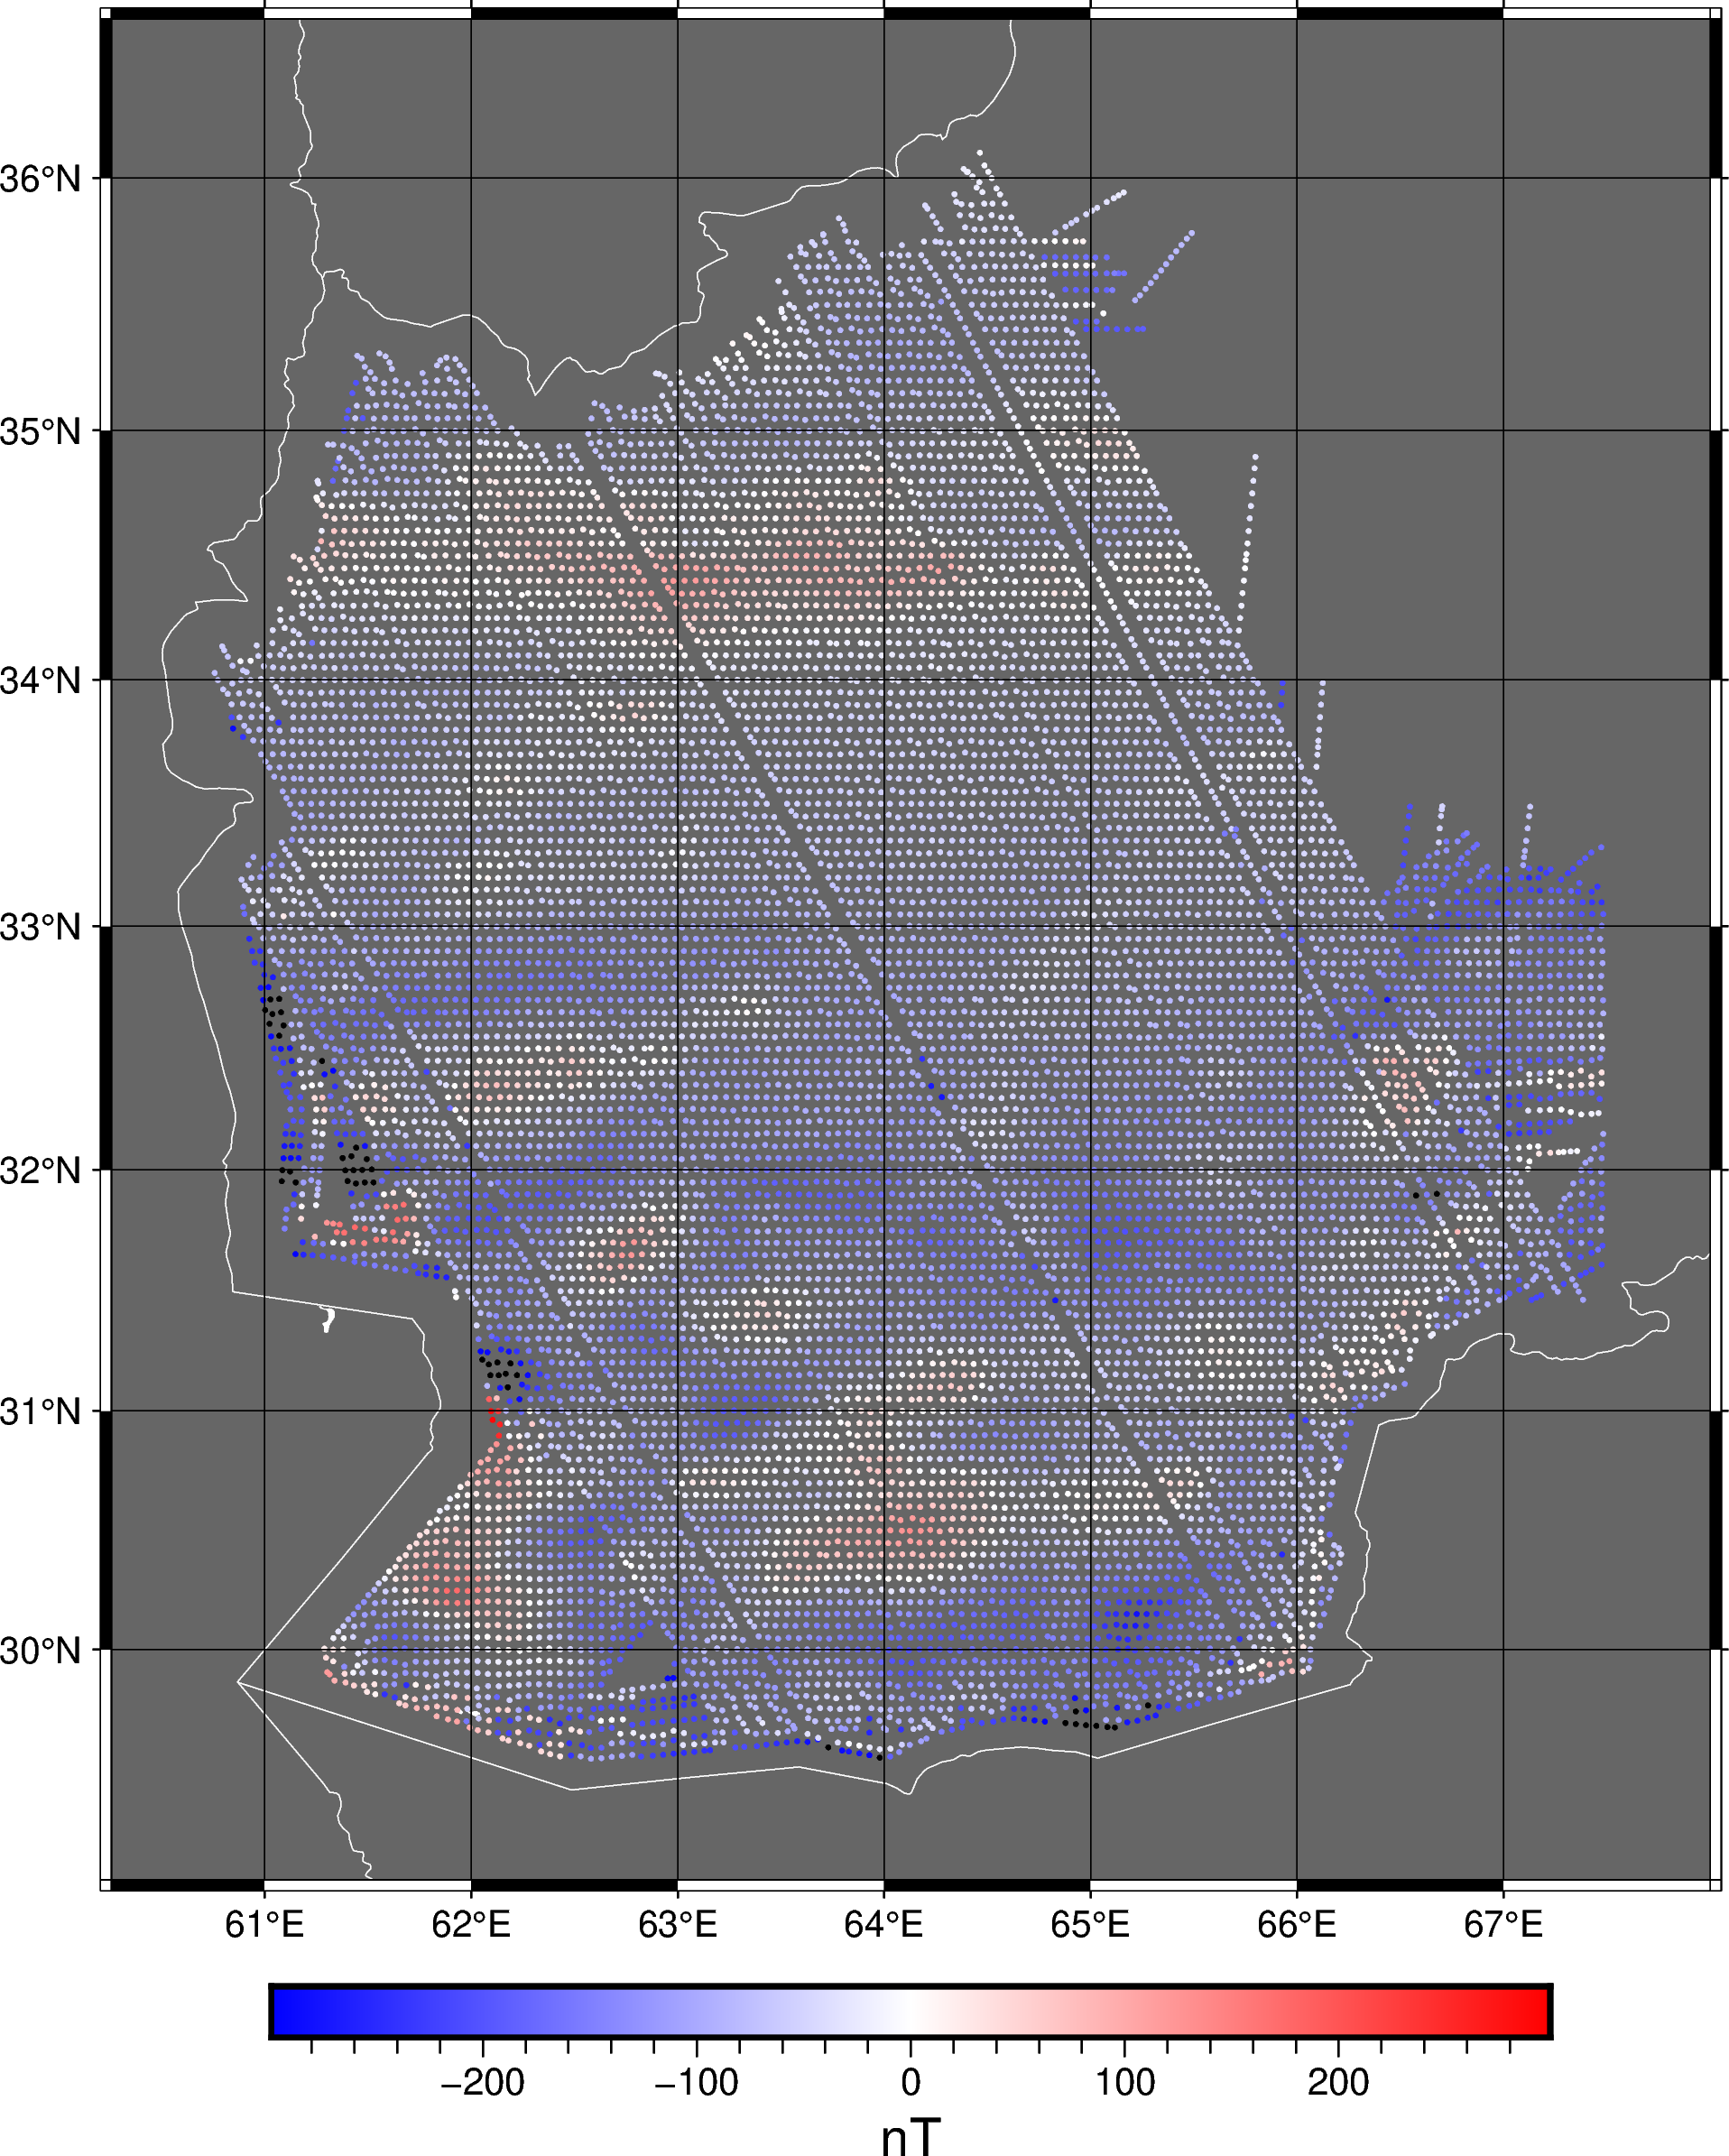

In [27]:
fig = pygmt.Figure()
fig.coast(region=region, projection="M15c", land="#666666", borders="1/white")
scale = 0.5 * vd.maxabs(data.total_field_anomaly_nt)
pygmt.makecpt(cmap="polar", series=[-scale, scale])
fig.plot(x=lon, y=lat, style="c0.05c", color=mag, cmap=True)
fig.colorbar(frame='af+l"nT"', position="JBC+o0/1c")
fig.basemap(frame="a1fg")
fig.show()

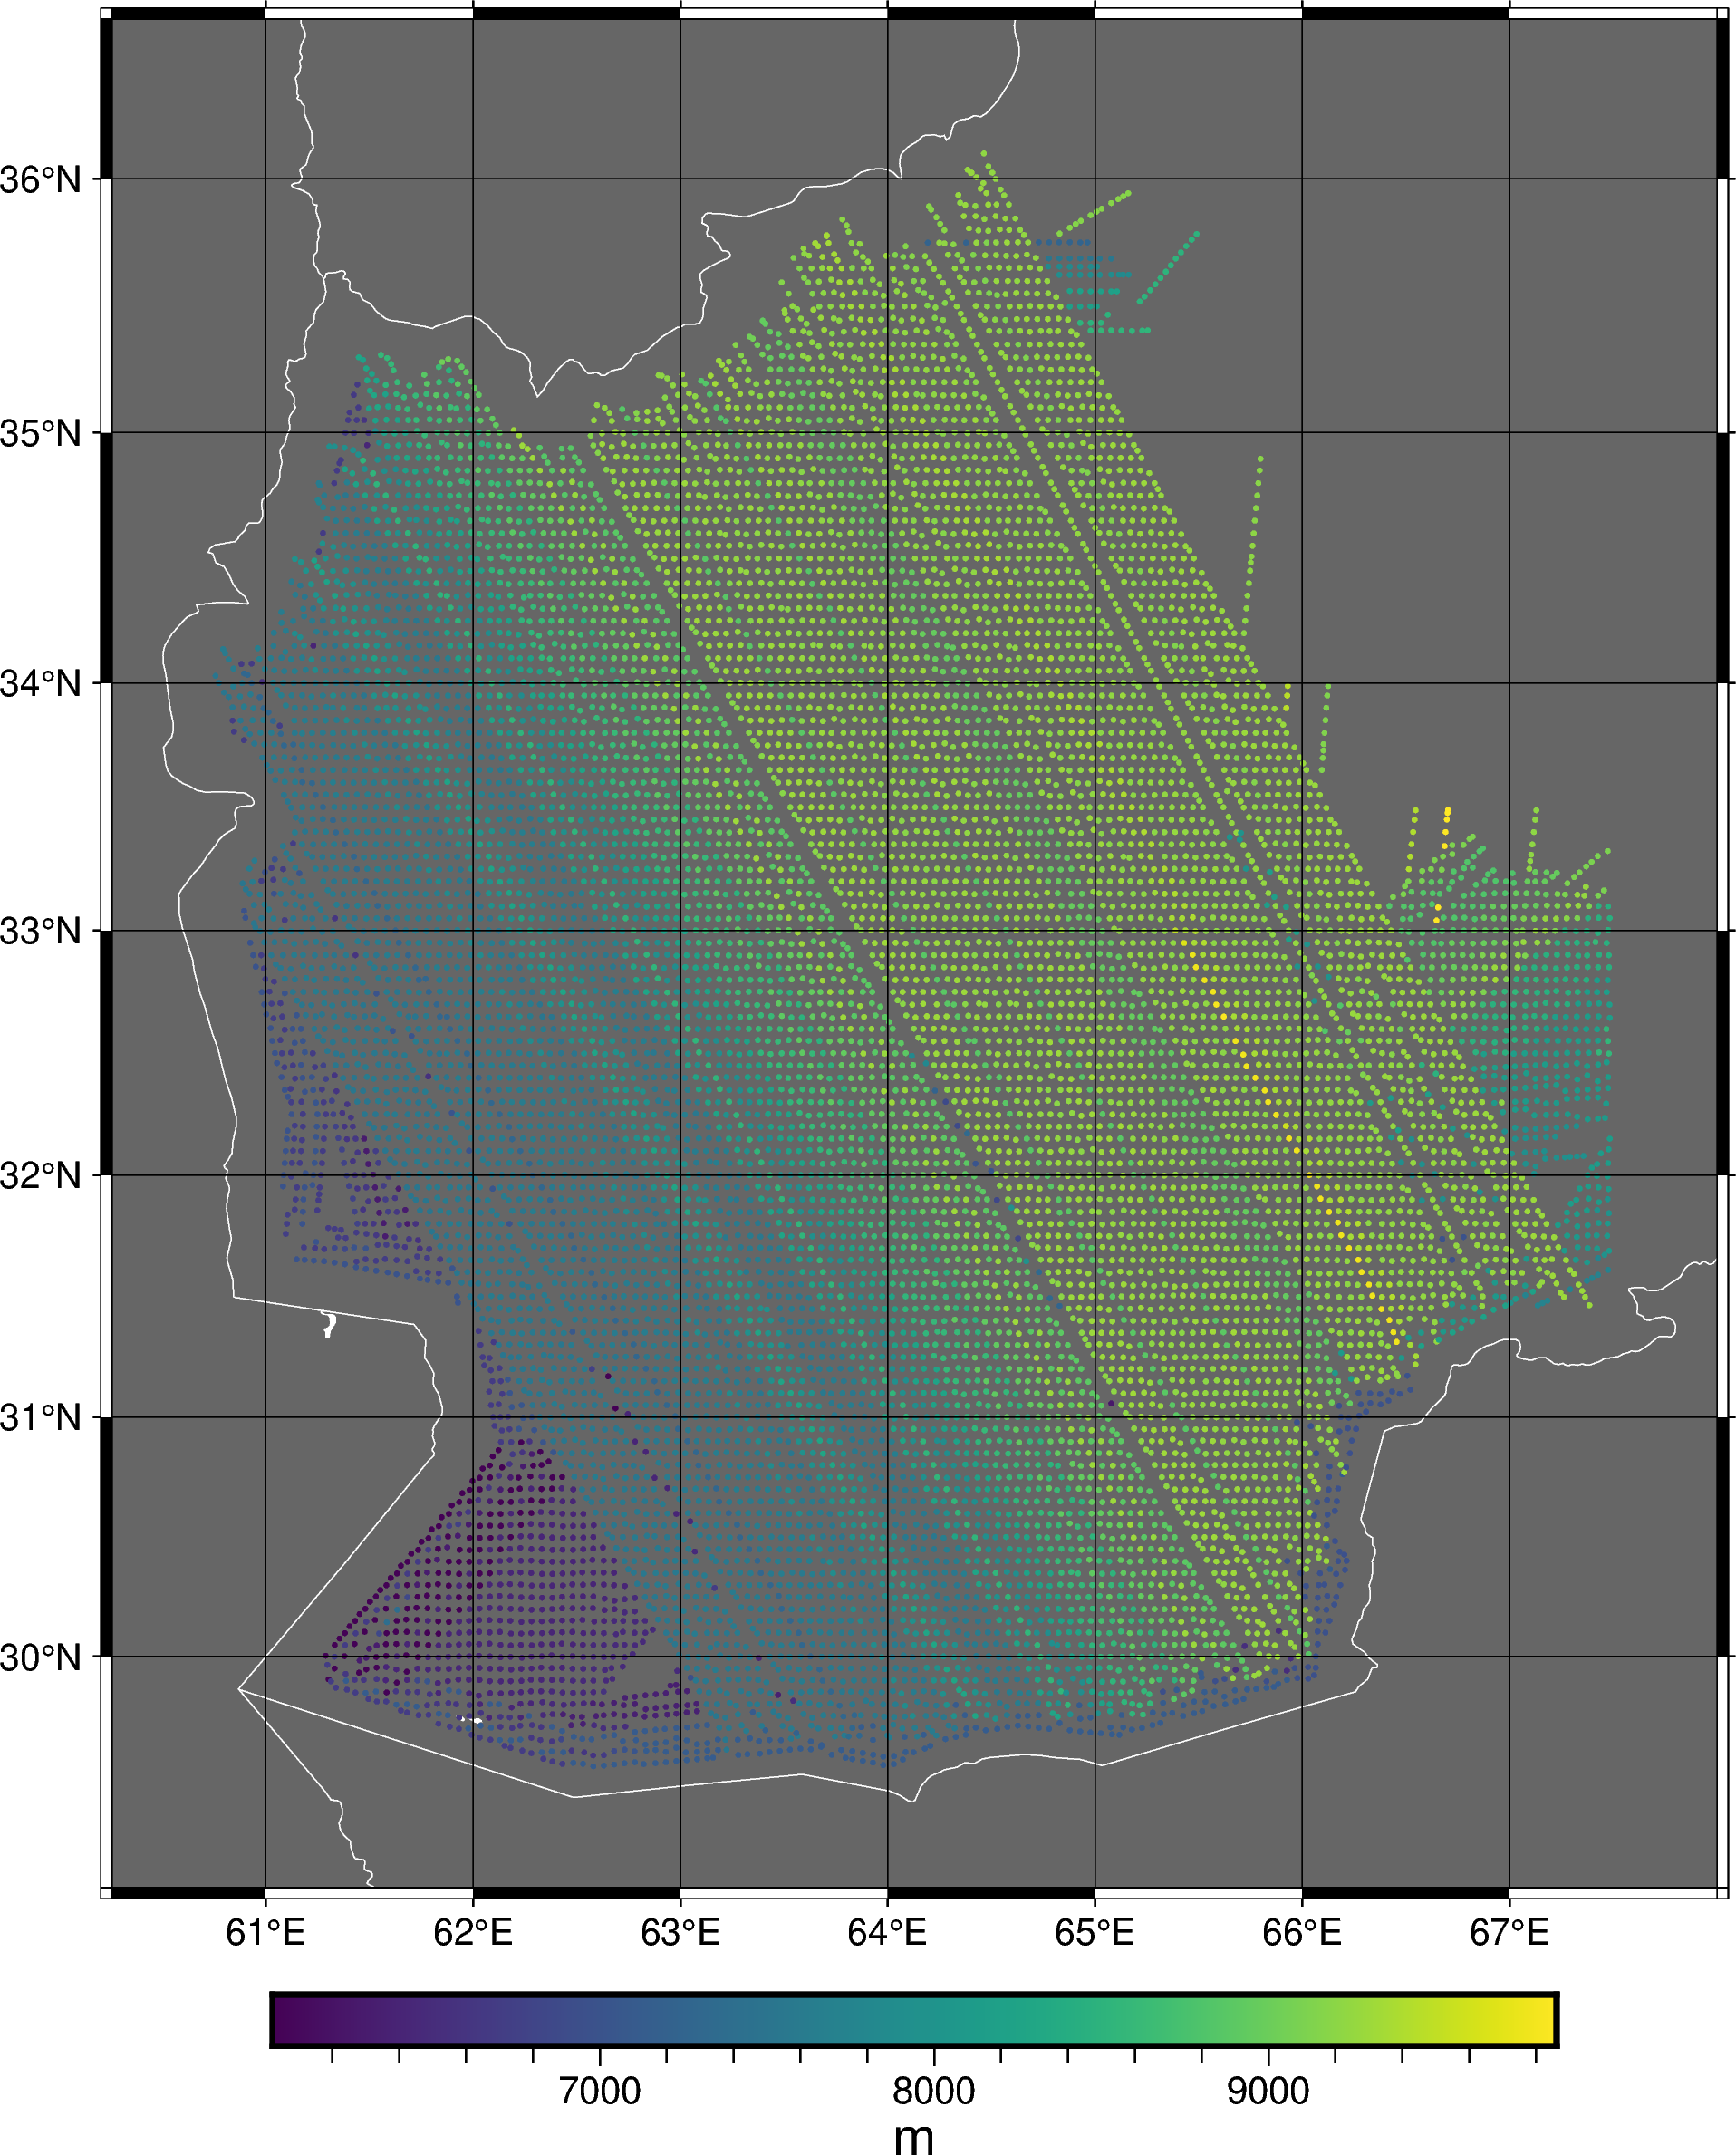

In [28]:
fig = pygmt.Figure()
fig.coast(region=region, projection="M15c", land="#666666", borders="1/white")
pygmt.makecpt(cmap="viridis", series=[h.min(), h.max()])
fig.plot(x=lon, y=lat, style="c0.05c", color=h, cmap=True)
fig.colorbar(frame='af+l"m"', position="JBC+o0/1c")
fig.basemap(frame="a1fg")
fig.show()

## Export

Make a separate DataFrame to export to CSV with only the chosen fields.

In [29]:
export = pd.DataFrame({  
    "time_utc": data.time_utc,  
    "longitude": data.longitude.map(lambda x: "{:.6f}".format(x)),
    "latitude": data.latitude.map(lambda x: "{:.6f}".format(x)),    
    "height_geometric_m": data.height_geometric_m.map(lambda x: "{:.1f}".format(x)),   
    "igrf_nt": data.igrf_nt.map(lambda x: "{:.1f}".format(x)),
    "magnetic_amplitude_nt": data.magnetic_amplitude_nt.map(lambda x: "{:.1f}".format(x)), 
})
export

,time_utc,longitude,latitude,height_geometric_m,igrf_nt,magnetic_amplitude_nt
0,2008-04-18 18:15:23,65.372620,31.449584,6767.6,47698.4,47419.9
1,2008-04-18 18:15:24,65.371095,31.449460,6767.6,47698.1,47419.3
2,2008-04-18 18:15:25,65.369594,31.449338,6767.7,47697.9,47418.7
3,2008-04-18 18:15:26,65.368069,31.449214,6767.7,47697.7,47417.2
4,2008-04-18 18:15:27,65.366543,31.449090,6767.6,47697.4,47416.4
...,...,...,...,...,...,...
4161646,2006-08-20 10:21:47,67.390133,31.453192,9284.8,47767.1,47658.5
4161647,2006-08-20 10:21:47,67.390227,31.453036,9284.8,47767.0,47658.4
4161648,2006-08-20 10:21:47,67.390307,31.452901,9284.8,47767.0,47658.3
4161649,2006-08-20 10:21:48,67.390388,31.452767,9284.7,47766.9,47658.2


In [17]:
fname = "afghanistan-magnetic.csv.xz"
export.to_csv(fname, index=False)
print(fname)
print(f"size: {os.path.getsize(fname) / 1e6} Mb")
for alg in ["md5", "sha256"]:
    print(f"{alg}:{pooch.file_hash(fname, alg=alg)}")

afghanistan-magnetic.csv.xz
size: 17.519408 Mb
md5:b5290cc6aacd0e71ad0d78b4275f614c
sha256:93f0b2efe391ce9465a6737566e262b054dc3990af5e4bd576ead45aae8f0f43


In [ ]:
del export

## Read back the data and plot it

Verify that the output didn't corrupt anything.

In [19]:
mag = pd.read_csv(fname)
mag

,longitude,latitude,height_geometric_m,igrf_nt,magnetic_amplitude_nt
0,64.867164,29.832119,7924.8,46708.2,46579.4
1,64.867067,29.832247,7924.8,46708.3,46579.6
2,64.866972,29.832375,7924.8,46708.3,46579.7
3,64.866861,29.832522,7924.7,46708.4,46579.8
4,64.866764,29.832650,7924.7,46708.4,46580.0
...,...,...,...,...,...
3664208,67.390133,31.453192,9284.8,47767.1,47658.5
3664209,67.390227,31.453036,9284.8,47767.0,47658.4
3664210,67.390307,31.452901,9284.8,47767.0,47658.3
3664211,67.390388,31.452767,9284.7,47766.9,47658.2


In [21]:
mag["total_field_anomaly_nt"] = mag.magnetic_amplitude_nt - mag.igrf_nt

In [26]:
(lon, lat), mag = blockmean.filter(
    (mag.longitude, mag.latitude), 
    mag.total_field_anomaly_nt,
)

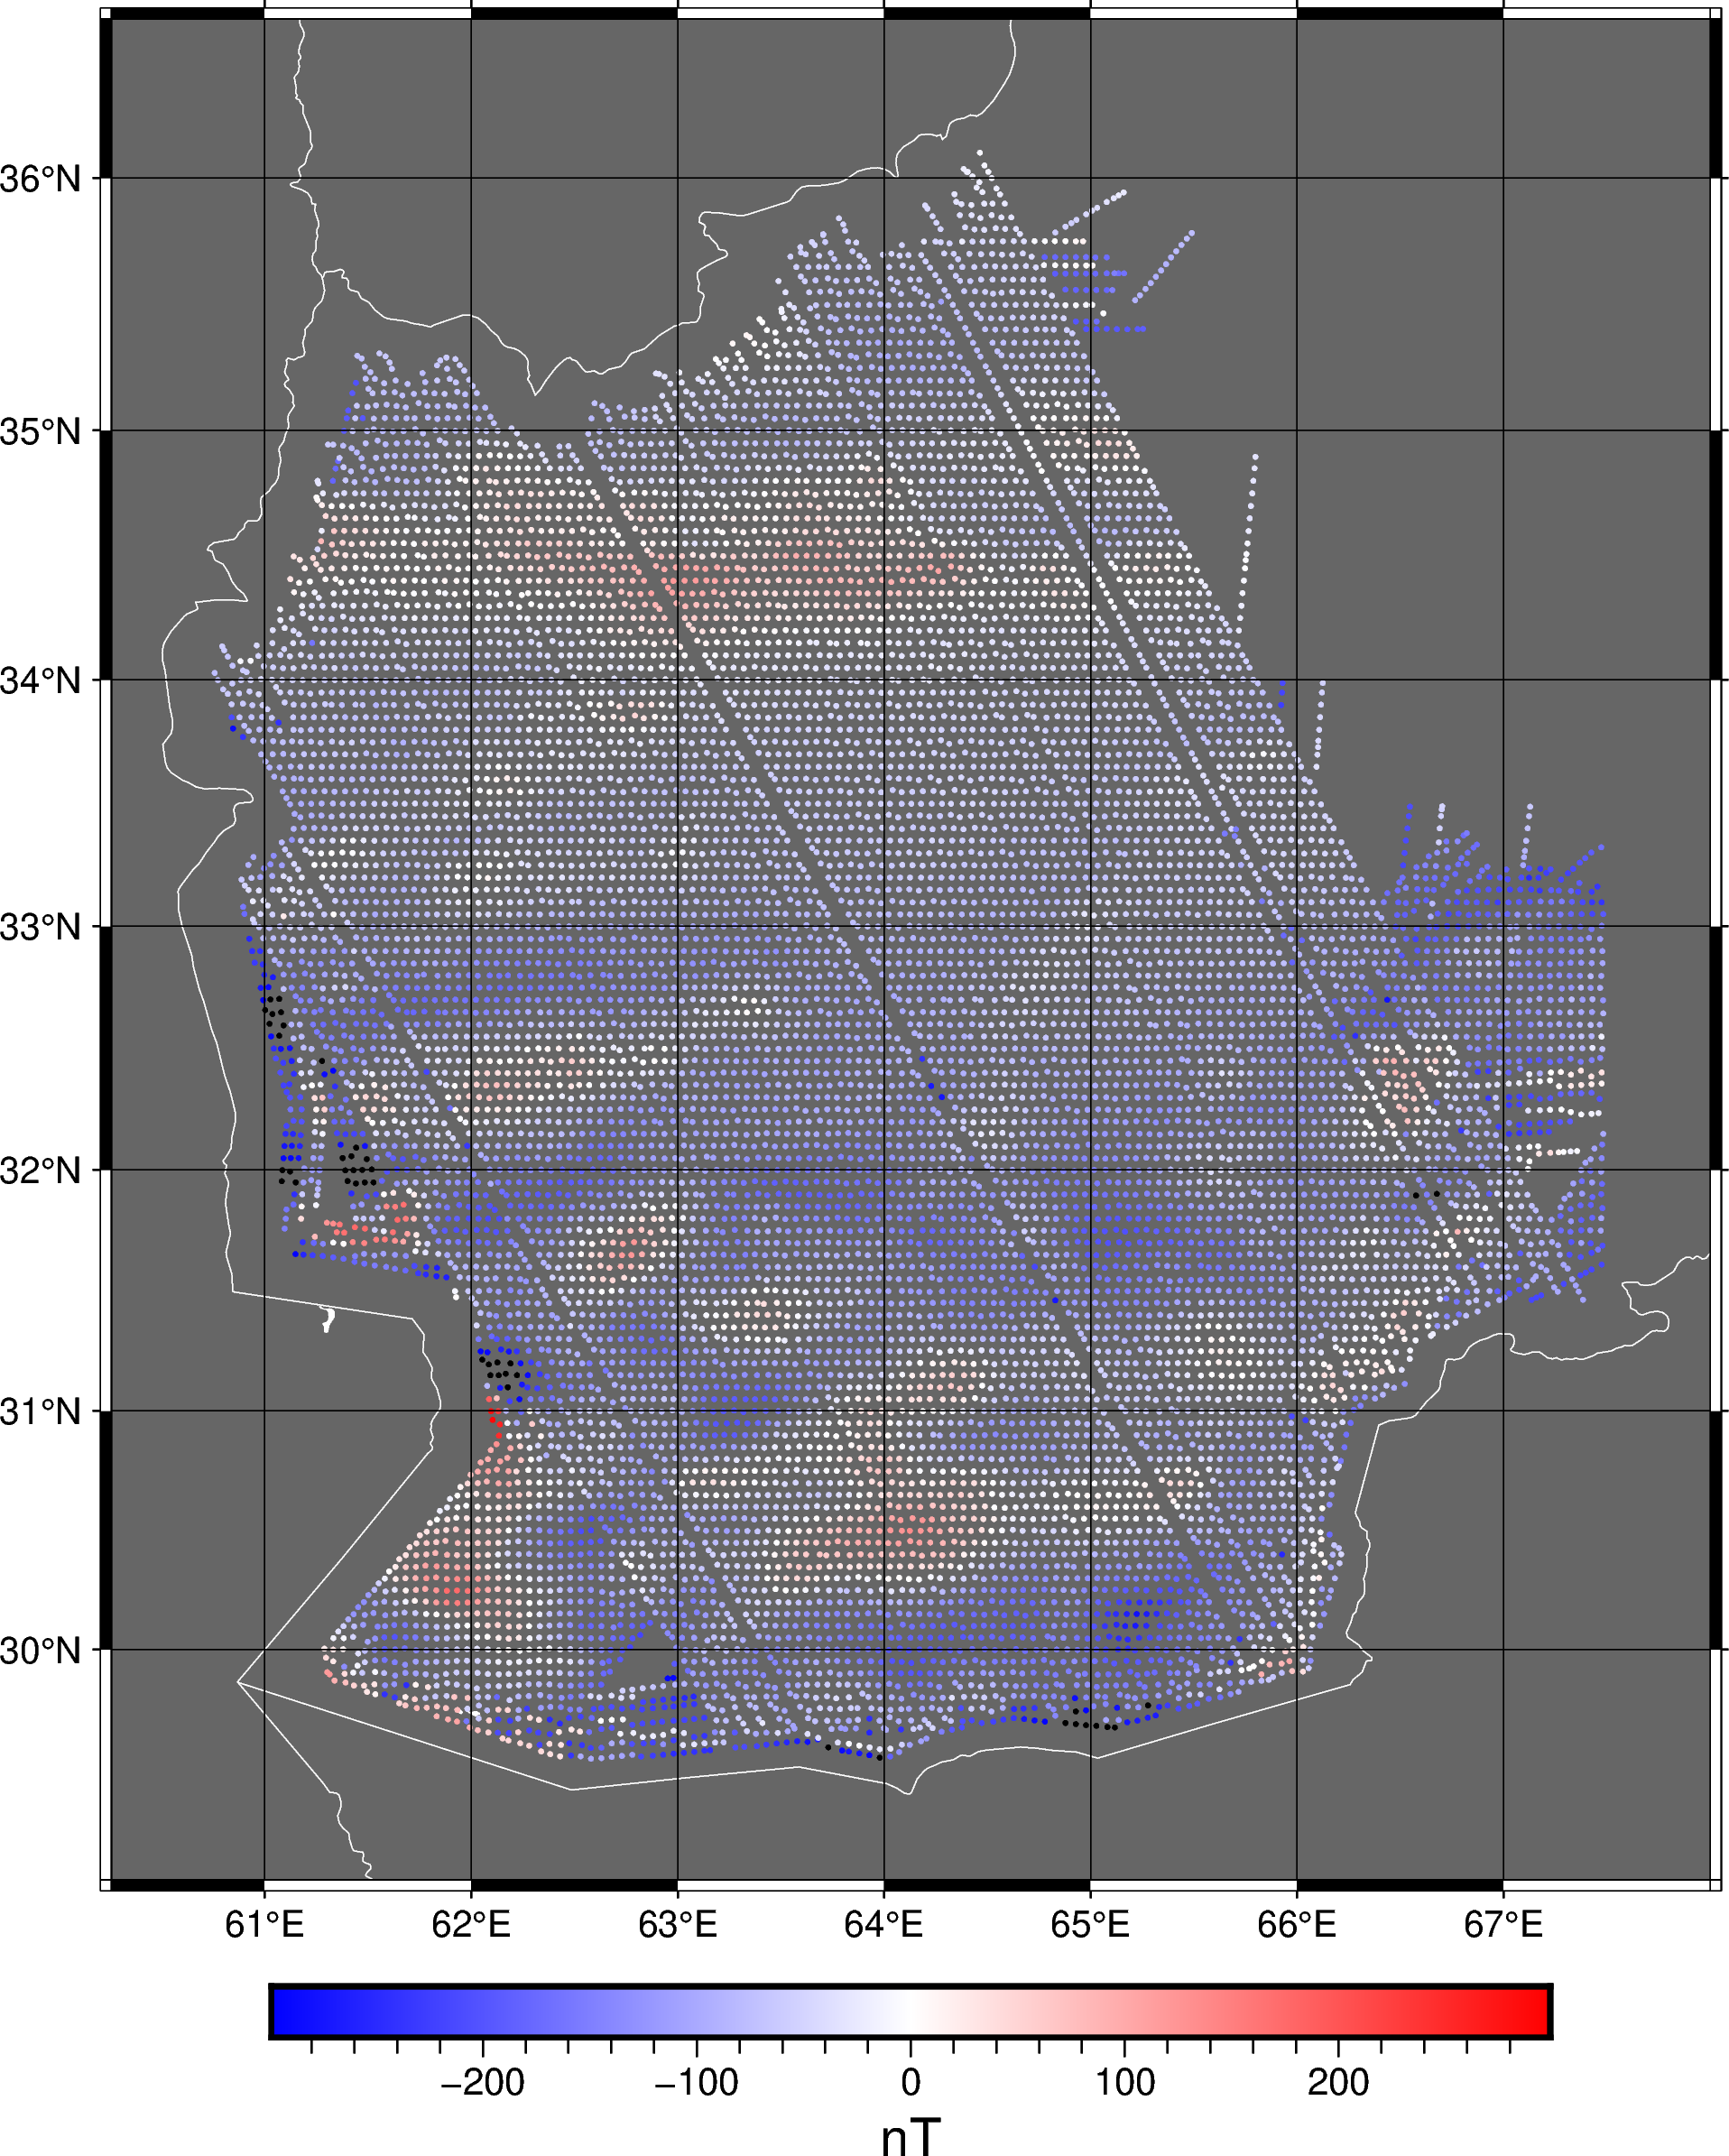

In [27]:
fig = pygmt.Figure()
fig.coast(region=region, projection="M15c", land="#666666", borders="1/white")
scale = 0.5 * vd.maxabs(mag.total_field_anomaly_nt)
pygmt.makecpt(cmap="polar", series=[-scale, scale])
fig.plot(x=lon, y=lat, style="c0.05c", color=mag, cmap=True)
fig.colorbar(frame='af+l"nT"', position="JBC+o0/1c")
fig.basemap(frame="a1fg")
fig.show()